# Bail Bonds Analysis
1. Merge case and offence
2. Find top offences that you get a bond for (felonies usually)
3. Find bond distributions for the top 3
4. Try visualizations with and without log scale

In [1]:
# load "clean" datasets
import pandas as pd

cases = pd.read_csv(
    "/Users/clarissaache/Documents/Capstone/JUSTFAIR_capstone/10_clean_data/cases_v01.csv",
    low_memory=False,
    index_col=[0],
)
offenses = pd.read_csv(
    "/Users/clarissaache/Documents/Capstone/JUSTFAIR_capstone/10_clean_data/offenses_v01.csv",
    low_memory=False,
    index_col=[0],
)


In [2]:
# Check unit of analysis:
cases.loc[cases["case_id"] == 9902021700564]


,case_id,key_county_num,key_county_num.1,key_century,key_year,court_type,def_street_address,def_city_address,def_state_address,def_zip_address,...,court_attorney_type,indictment_date,bond_type,bond_amount,in_jail_indicator,jail_release_date,jail_commited_date,arrest_date,domestic_violence,race_gender
14081542,9902021700564,990,990,20,21,CR,436 BILL ALLEN BRANC,BURNSVILLE,NC,28714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,White Male


In [3]:
# One case = Two Offenses
offenses.loc[offenses["case_id"] == 9902021700564]


,case_id,CRRKEY,charged_offense_date,charged_offense_code,arraigned_offense_date,convicted_offense_code,plea_code,verdict_code,disposition,disposition_date,...,domestic_violence_flag,active_sentence_ind,community_service_hr,offense_class,prior_record_points,judgement_file_number,judgement_file_offense_num,court_cost,min_sentence_day,max_sentence_day
23039396,9902021700564,990202170056400201001100,2021-06-28,5461,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23039397,9902021700564,990202170056400302001100,2021-06-28,4470,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# (1) Merge
case_off = pd.merge(
    cases, offenses, on="case_id", how="left", validate="m:m", indicator=True
)
case_off._merge.value_counts()


both          23039404
left_only            0
right_only           0
Name: _merge, dtype: int64

In [5]:
# ------------------------ SAVE THE MERGE BC IT TOOK A FOREVER ------------------------ #
case_off.drop("_merge", axis=1, inplace=True)

# case_off.to_csv("/Users/clarissaache/Documents/Capstone/JUSTFAIR_capstone/10_clean_data/case_offense_v01.csv")


In [6]:
# validate there are two entries
case_off.loc[case_off["case_id"] == 9902021700564]


,case_id,key_county_num,key_county_num.1,key_century,key_year,court_type,def_street_address,def_city_address,def_state_address,def_zip_address,...,domestic_violence_flag,active_sentence_ind,community_service_hr,offense_class,prior_record_points,judgement_file_number,judgement_file_offense_num,court_cost,min_sentence_day,max_sentence_day
23039396,9902021700564,990,990,20,21,CR,436 BILL ALLEN BRANC,BURNSVILLE,NC,28714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23039397,9902021700564,990,990,20,21,CR,436 BILL ALLEN BRANC,BURNSVILLE,NC,28714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Merge with offence code descriptions:
offense_desc = pd.read_csv(
    "/Users/clarissaache/Documents/Capstone/JUSTFAIR_capstone/00_raw_data/ACIS_offence_codes.csv"
)

case_off_desc = pd.merge(
    left=case_off,
    right=offense_desc,
    left_on="charged_offense_code",
    right_on="CODE",
    how="left",
    validate="m:m",
    indicator=True,
)
case_off_desc._merge.value_counts()


both          31148063
left_only         5997
right_only           0
Name: _merge, dtype: int64

In [86]:
offense_desc.sample(3)

,D,CODE,T,Offense Description,NC General Statute,Offense Start Date,Offense End Date,CL,Class Start Date,Class End Date,DWI and IC Report,Max Date
464,NaN,2693,F,DEFRAUD DRUG/ALC TEST SUBOFN,14-401.20,20170810,99999999,I,20170810.0,99999999.0,No,20170810
524,NaN,3314,F,ATTEMPT POSSESS MEPHEDRONE,90-95(A)(3),20110601,99999999,I,20110601.0,99999999.0,No,20110601
92,NaN,1159,M,SEXUAL BATTERY,14-27.33,20151201,99999999,A1,20151201.0,99999999.0,No,20151201


CAREFUL HERE! There are 5997 codes that did not match.

For now, I will not do anything about that

<AxesSubplot:title={'center':'Most Common Charged Offences in NC in years 2017-2021 \n(with more than 0.5% of total offense occurrences)'}, xlabel='Offense Description', ylabel='% Frequency of Offense'>

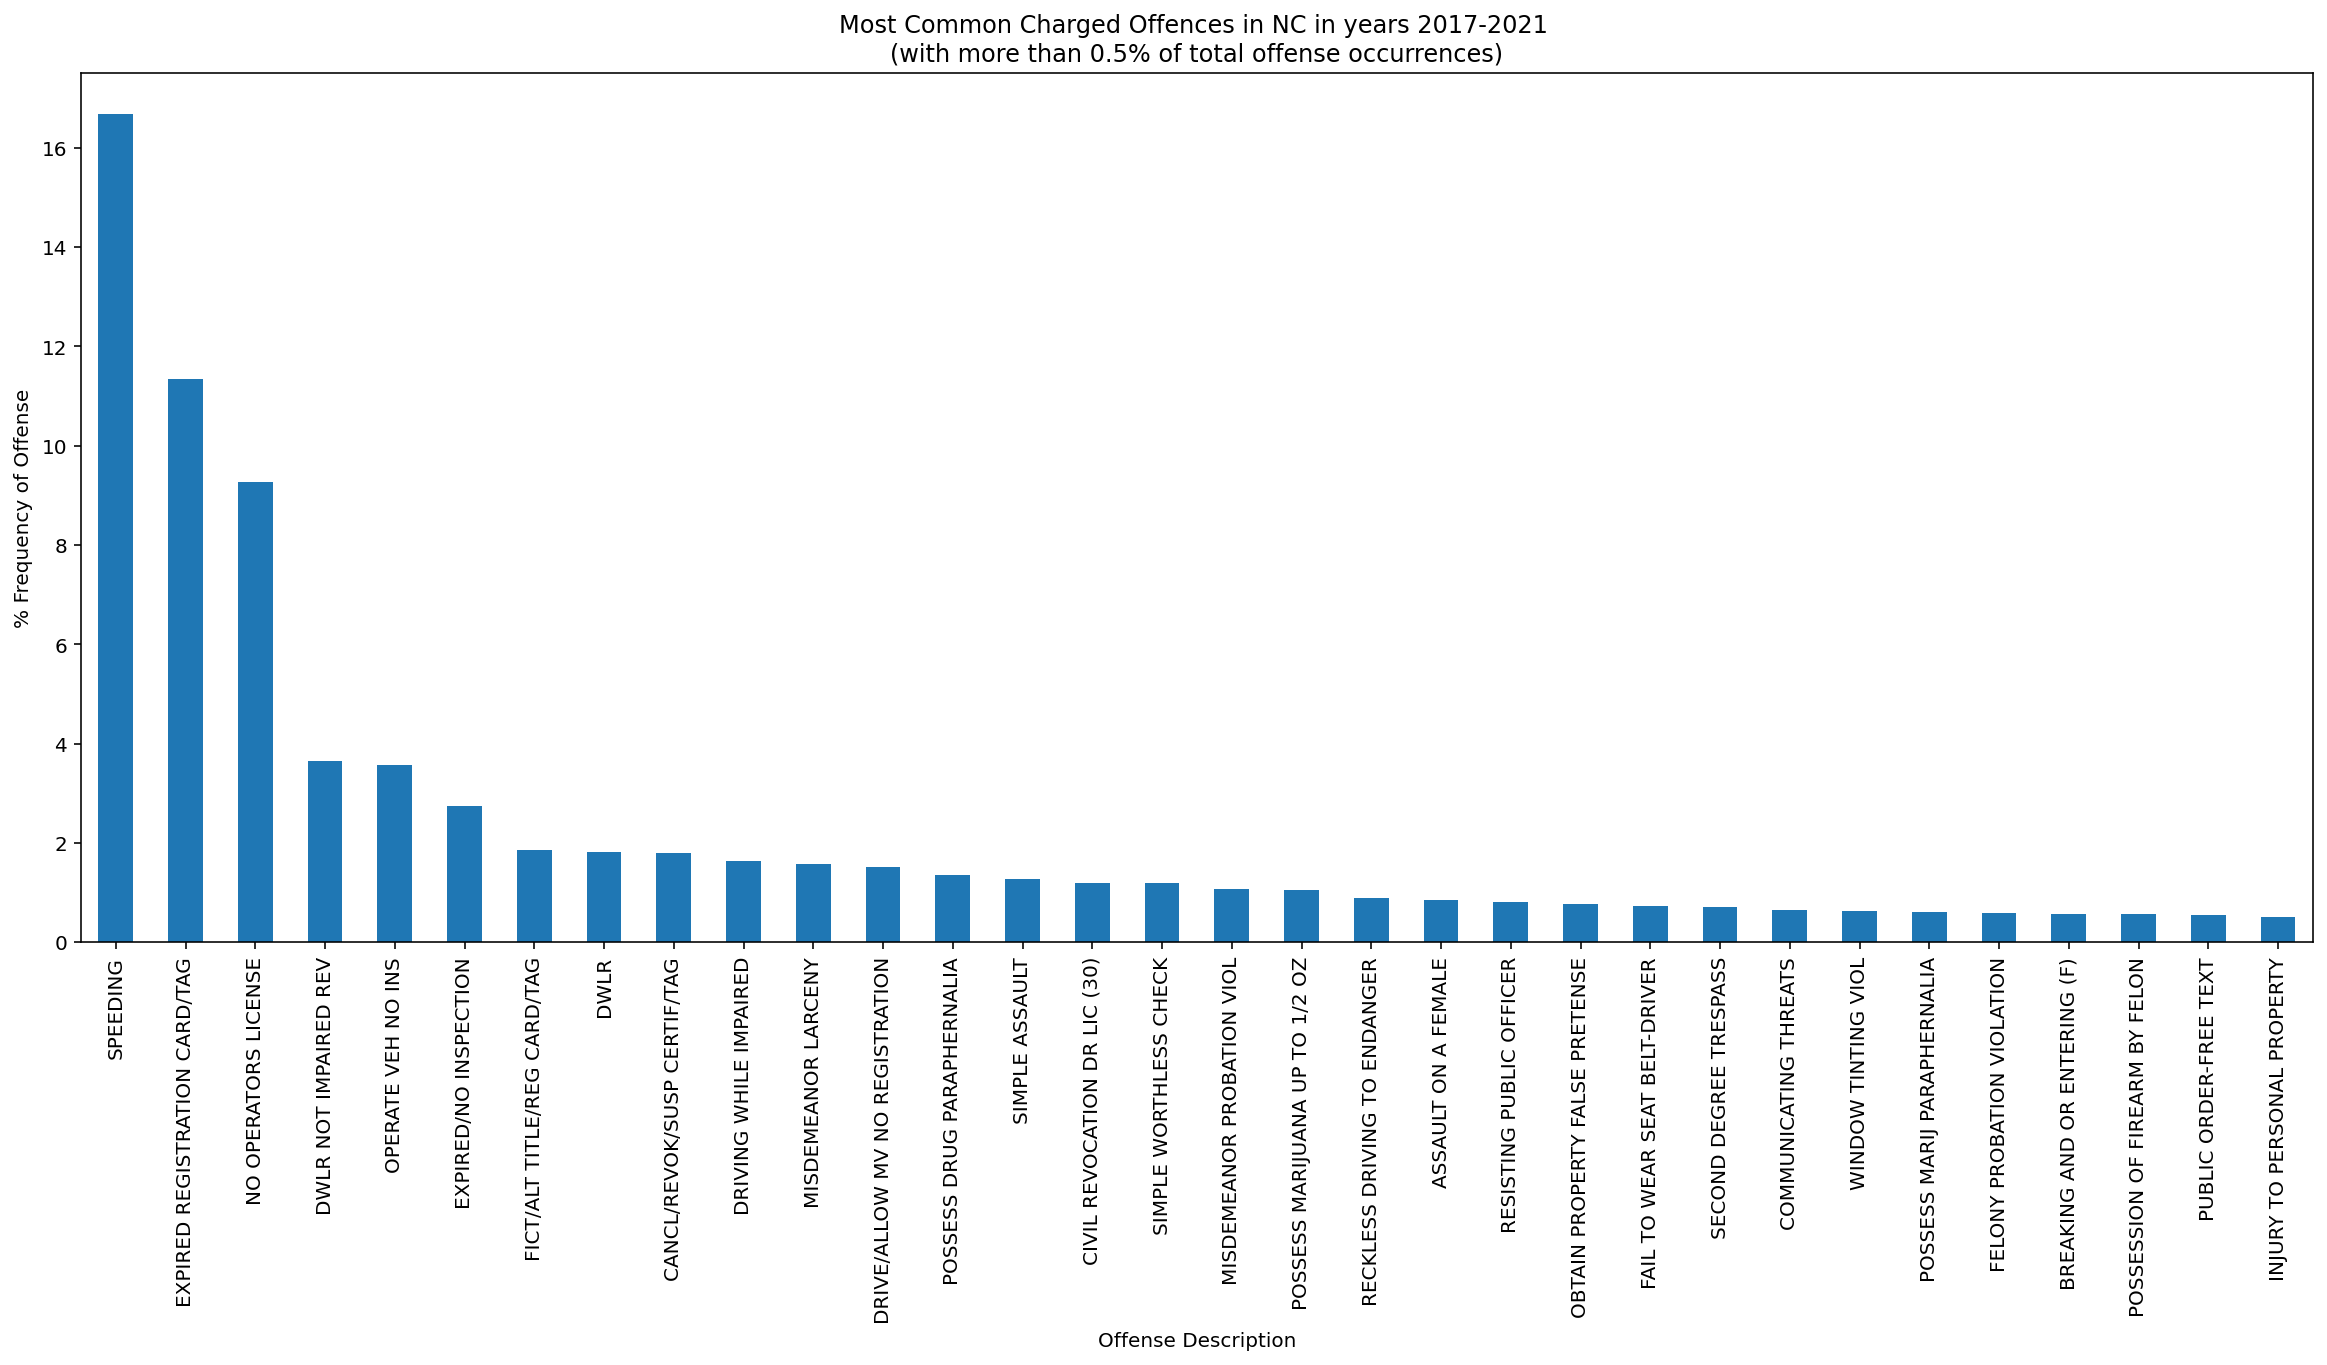

In [8]:
# Top offences PLOT#1
top_offenses = pd.DataFrame(case_off_desc["Offense Description"].value_counts())

# It would be cool to show the driving-related ones in a different color...

import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'retina'
top_offenses['%']=100 * top_offenses['Offense Description'] / np.sum(top_offenses['Offense Description'])

top_offenses.loc[top_offenses["%"] > 0.5]['%'].plot(
    kind="bar",
    figsize=(20, 8),
    xlabel="Offense Description",
    ylabel="% Frequency of Offense",
    title="Most Common Charged Offences in NC in years 2017-2021 \n(with more than 0.5% of total offense occurrences)",
    legend=False,
)


<AxesSubplot:title={'center':'Most Common Charged Offences in NC that are assigned a bail bond (>=$0) in years 2017-2021 \n(with more than 0.5% of total offense occurrences)'}, xlabel='Offense Description', ylabel='Frequency (Number of Occurences)'>

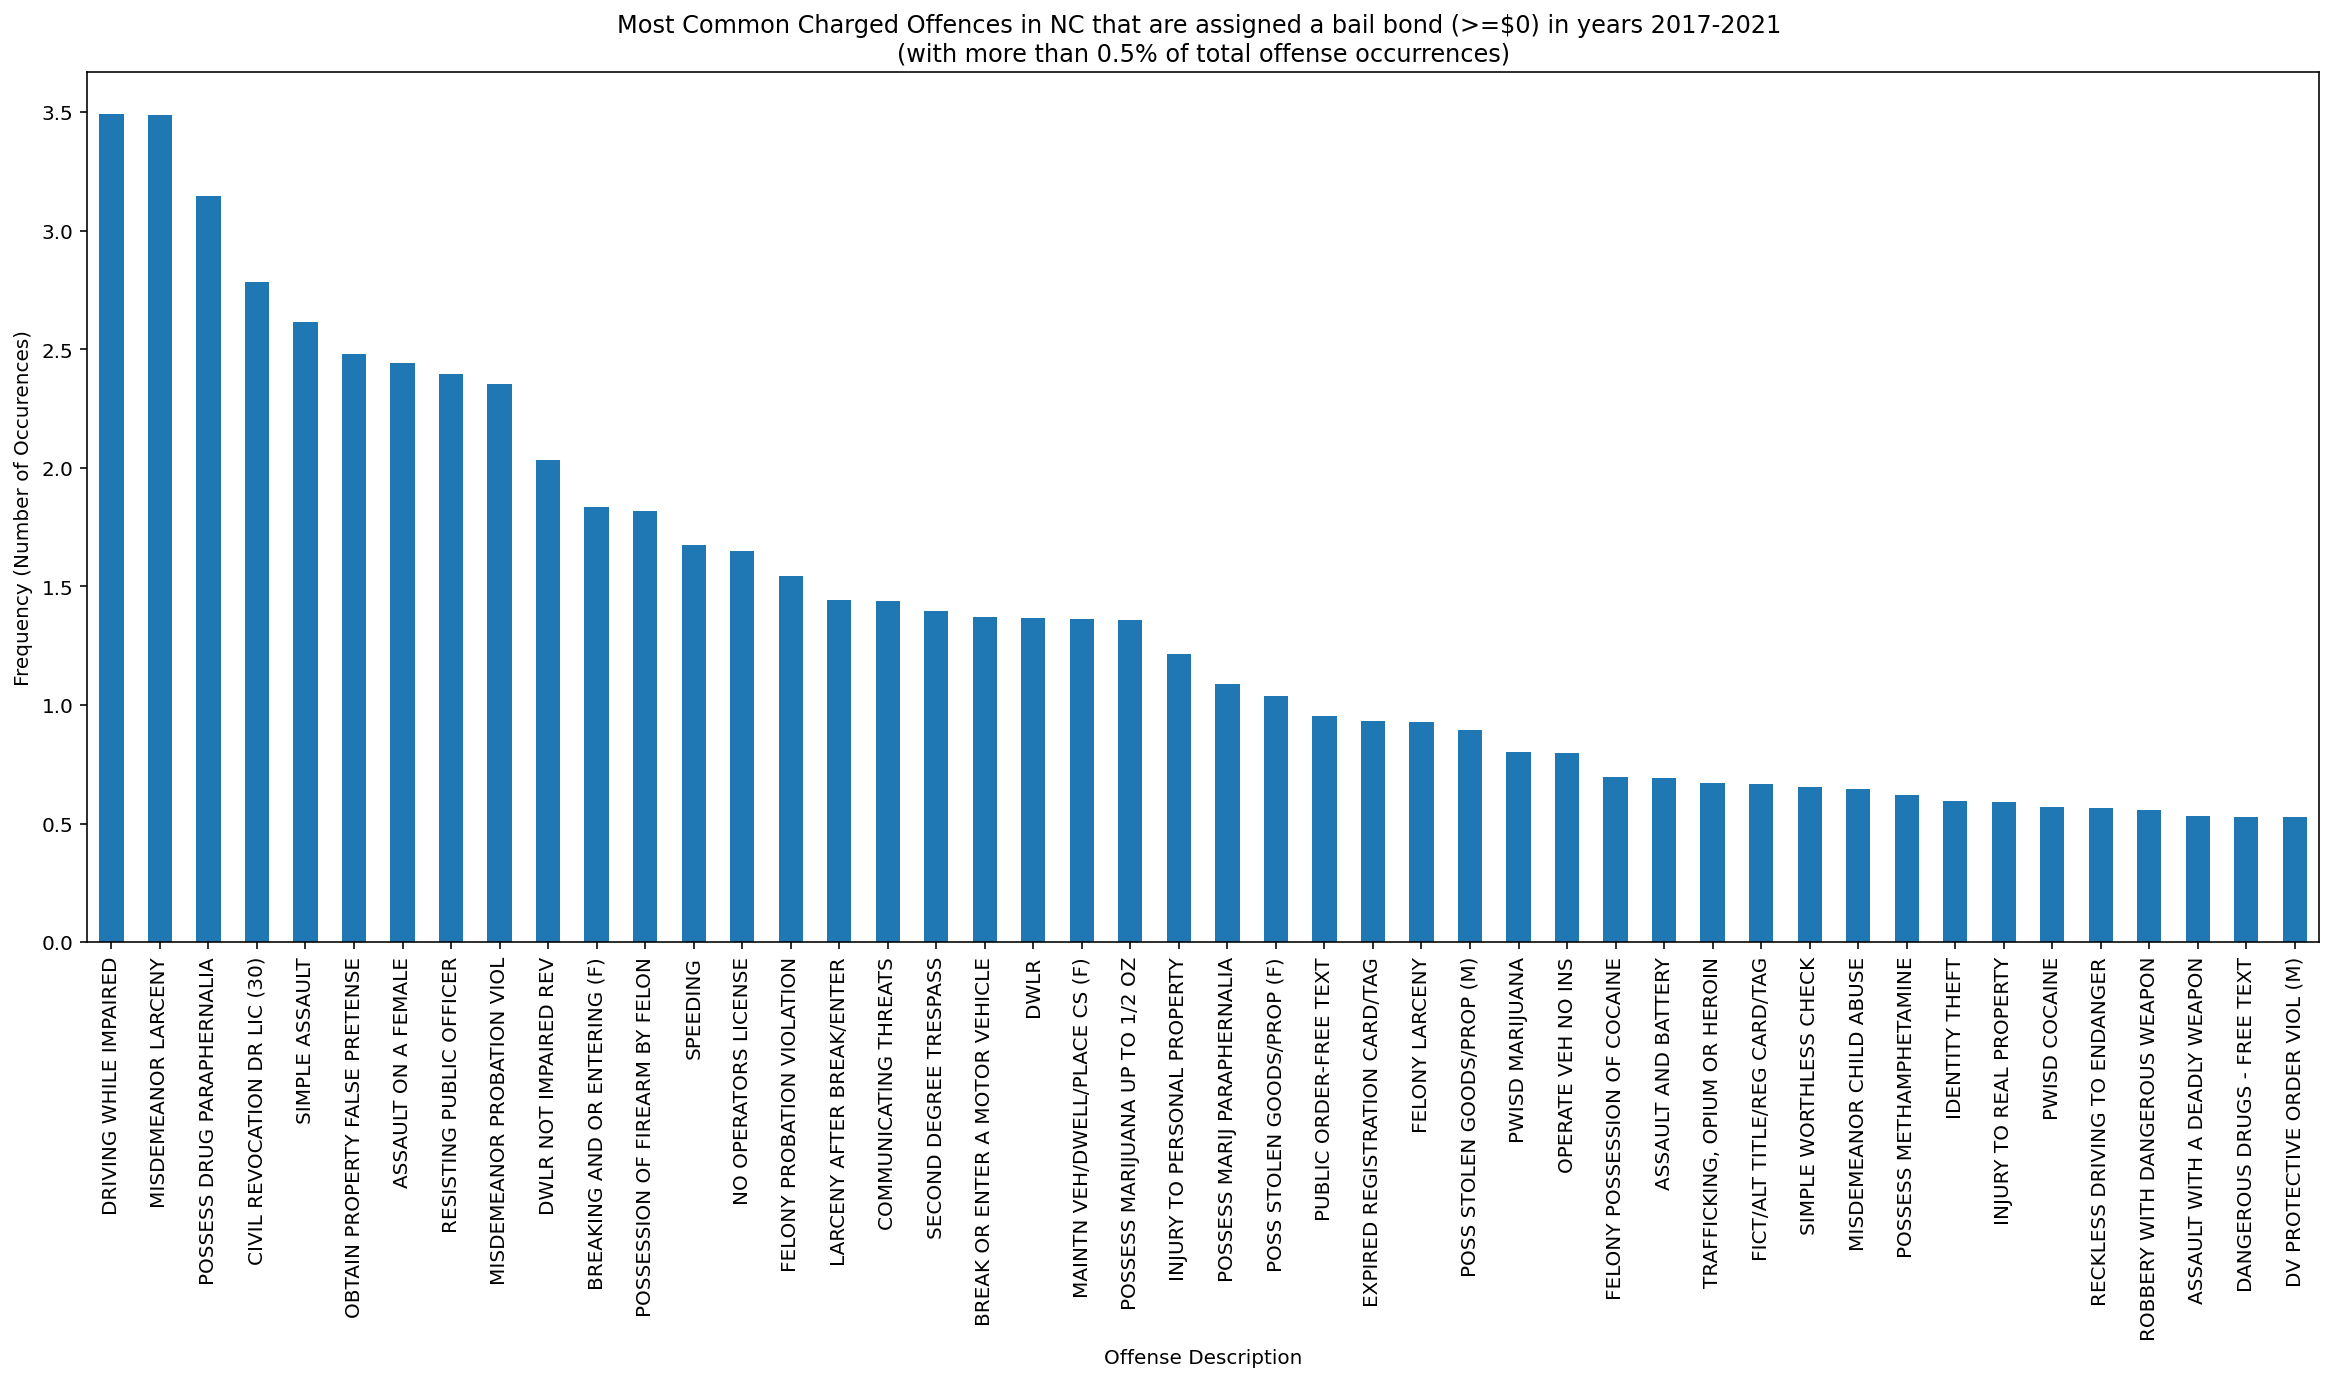

In [10]:
# (2) Find top 5 offences you get a bond for
#           Note: Bond amount may be missing instead of being 0 which will skew the data.

import matplotlib.pyplot as plt

# keep only bond amounts that are not NA
bond_data = case_off_desc[~case_off_desc["bond_amount"].isna()]


# these are the ones that have the most bond associated records
top_offences_with_bail = pd.DataFrame(bond_data["Offense Description"].value_counts())
top_offences_with_bail["%"] = (
    100
    * top_offences_with_bail["Offense Description"]
    / np.sum(top_offences_with_bail["Offense Description"])
)
top_offences_with_bail.loc[top_offences_with_bail["%"] > 0.5]["%"].plot(
    kind="bar",
    figsize=(20, 8),
    xlabel="Offense Description",
    ylabel="Frequency (Number of Occurences)",
    title="Most Common Charged Offences in NC that are assigned a bail bond (>=$0) in years 2017-2021 \n(with more than 0.5% of total offense occurrences)",
    legend=False,
)


# Bail Bonds for #1: "DRIVING WHILE IMPAIRED"

In [11]:
top_five_offences_with_bonds = [5405, 2322, 3401, 9955, 2632]

# Lets just do the first one, for now
case_bond = case_off_desc.loc[case_off_desc["charged_offense_code"] == 5405]

percent_missing = (
    case_bond["bond_amount"].isnull().sum() * 100 / len(case_bond["bond_amount"])
)
percent_missing

# This is a problem, the data may be skewed :(
# We can assume missing data is not caused by anything related to gender (missing for random columns or bc charges were dropped?)


45.40615802181921

<AxesSubplot:title={'center':'Are bail $ amounts missing for some races more than others?? \n (doesnt look like it!)'}, xlabel='race', ylabel='% of entries'>

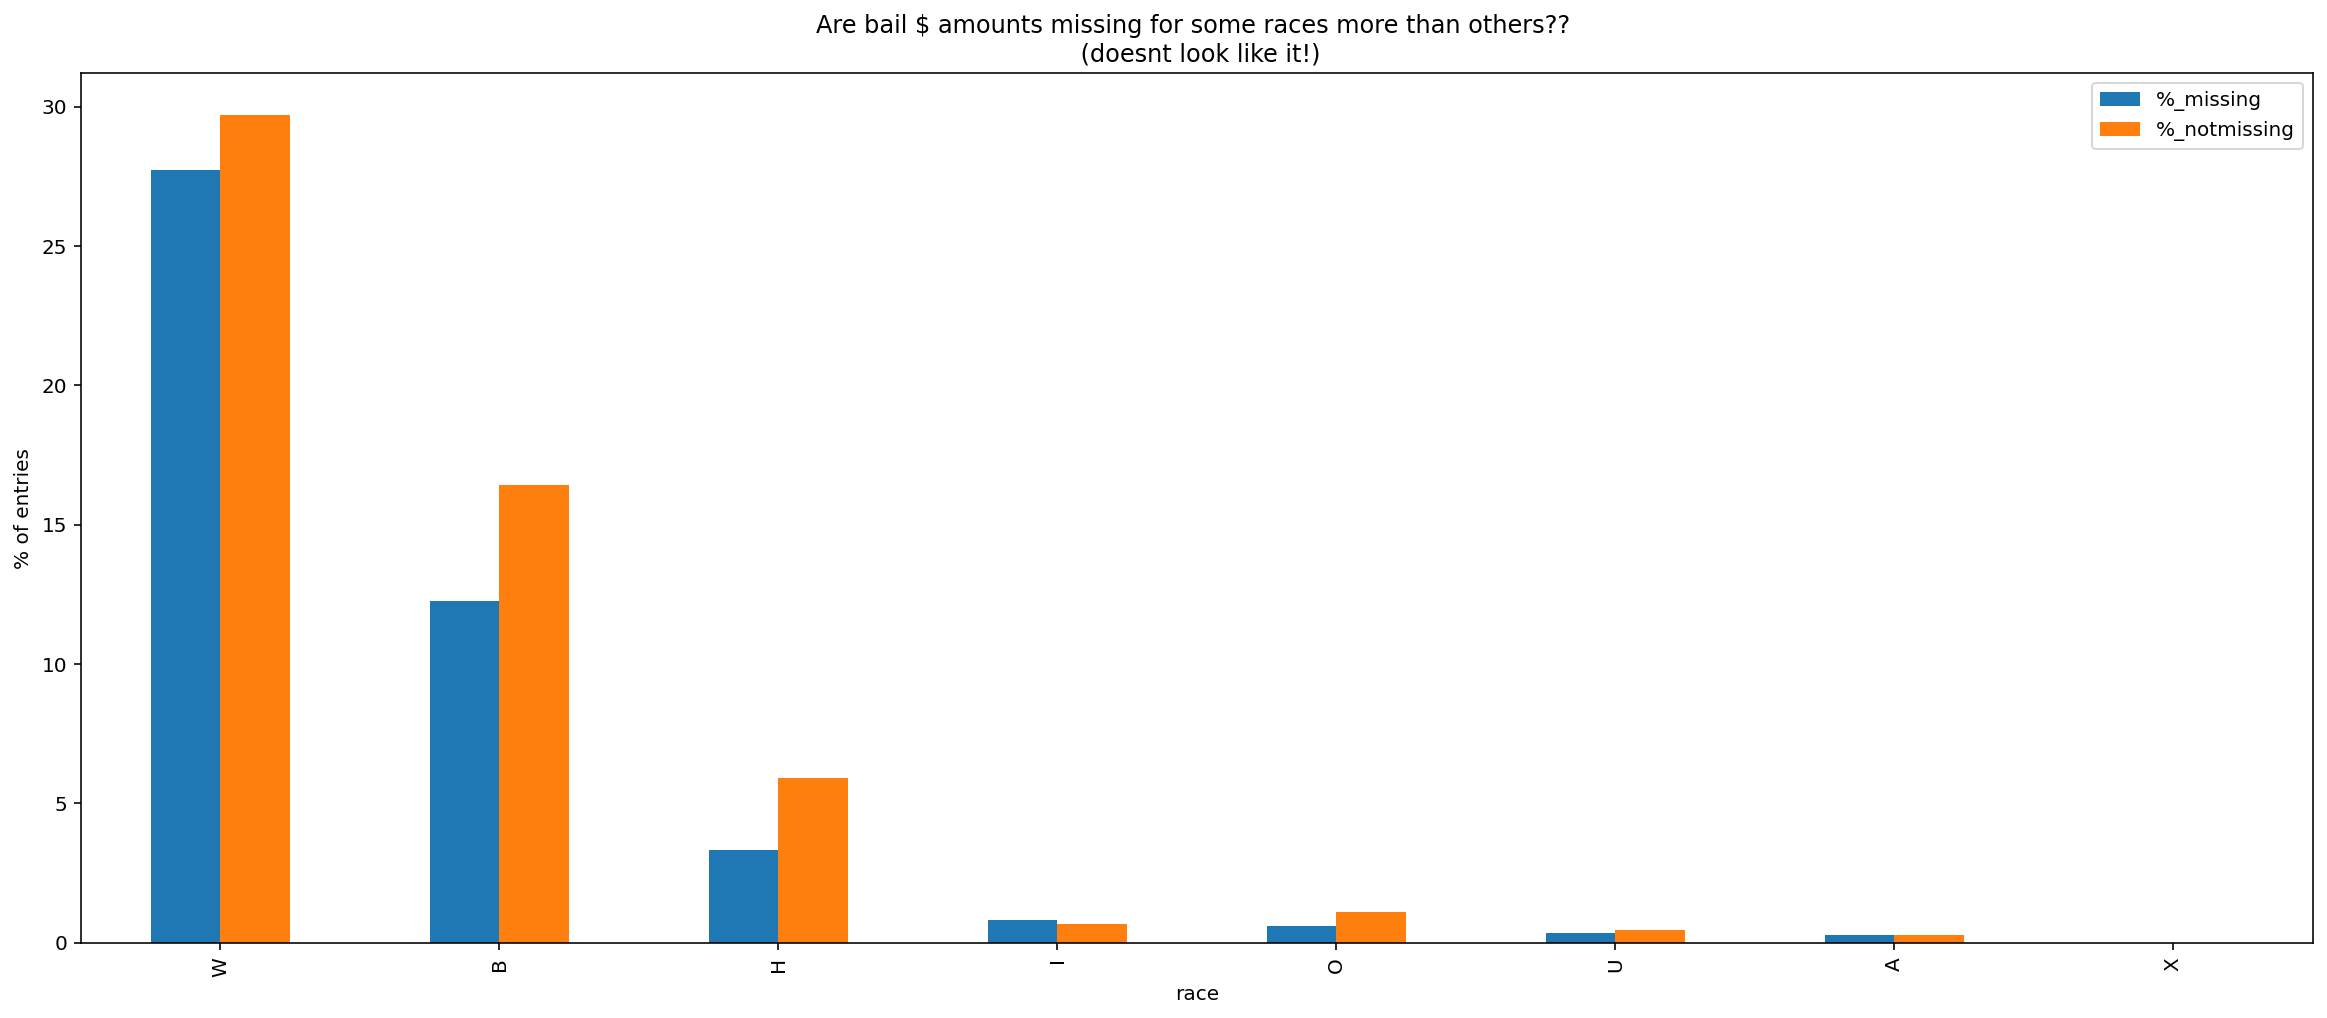

In [12]:
# lets look at race dist of non-missing amounts vs. missing amounts:

# not missing
not_missing_data_bail = pd.DataFrame(
    case_bond.loc[~case_bond["bond_amount"].isnull(), "race"].value_counts()
)
not_missing_data_bail

not_missing_data_bail["%_notmissing"] = (
    100 * not_missing_data_bail["race"] / len(case_bond.index)
)

# missing
missing_data_bail = pd.DataFrame(
    case_bond.loc[case_bond["bond_amount"].isnull(), "race"].value_counts()
)
missing_data_bail
missing_data_bail["%_missing"] = 100 * missing_data_bail["race"] / len(case_bond.index)

missing_data_bail = pd.concat([missing_data_bail, not_missing_data_bail], axis=1)
missing_data_bail[["%_missing", "%_notmissing"]].plot(
    kind="bar",
    figsize=(20, 8),
    xlabel="race",
    ylabel="% of entries",
    title="Are bail $ amounts missing for some races more than others?? \n (doesnt look like it!)",
    legend=True,
    # stacked=True,
)


In [ ]:
# Look for cases that are not so recent or resolved cases

In [13]:
case_off_desc["bond_type"].value_counts()


SEC    6080373
UNS    1504717
WPA     628966
CSH     308456
CUS     222193
PTR      11792
DIS       1248
INC         18
COM          7
PAI          5
VD           5
RB           4
P/O          3
USB          3
SB           2
PD           1
UBP          1
C&F          1
DBR          1
Name: bond_type, dtype: int64

In [14]:
case_bond.bond_type.value_counts()


SEC    169487
UNS     85090
WPA     81229
CUS     55218
CSH     18731
PTR       325
DIS        18
INC         2
Name: bond_type, dtype: int64

Bond Type Code<br>
* CSH - Cash 
* CUS - Custody Release
* PTR - Pretrial Release  
* SEC - Secured
* UNS - Unsecured 
* WPA - Written Promise to Appear

"There are two types of bonds – secured and unsecured. A secured bond means that you actually pay money or bail property to secure your release. An unsecured bond or surety bond means you sign a document that says you will pay a certain amount of money if the defendant breaks his/her bond conditions."

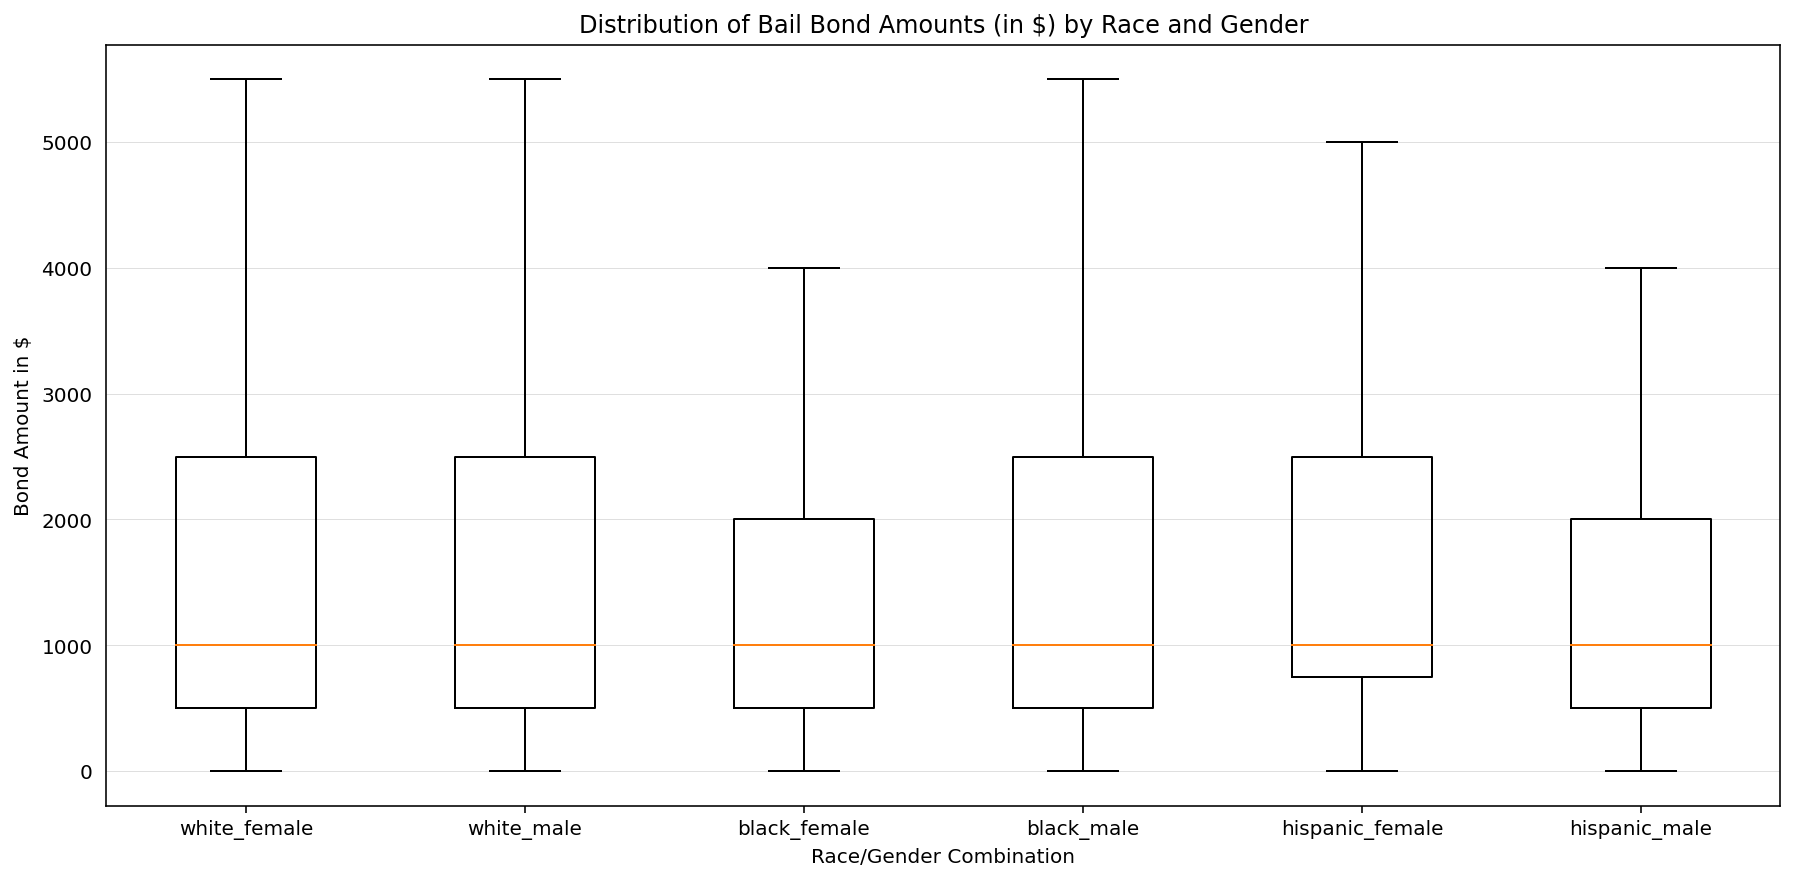

In [15]:
# So, because I saw that the distributions by race of missing vs. not missing bond amount is fairly similar, I will just use the ones that are not missing
case_bond = case_bond.loc[case_bond["bond_amount"] >= 0]
# case_bond = case_bond.loc[case_bond['bond_type'].isin(['CSH', 'CUS', 'PTR', 'SEC', 'UNS', 'WPA'])]

# Prepare loudness by genre datasets
white_female = case_bond[case_bond["race_gender"] == "White Female"]["bond_amount"]
white_male = case_bond[case_bond["race_gender"] == "White Male"]["bond_amount"]
black_female = case_bond[case_bond["race_gender"] == "Black Female"]["bond_amount"]
black_male = case_bond[case_bond["race_gender"] == "Black Male"]["bond_amount"]
hispanic_female = case_bond[case_bond["race_gender"] == "Hispanic Female"][
    "bond_amount"
]
hispanic_male = case_bond[case_bond["race_gender"] == "Hispanic Male"]["bond_amount"]


# Visualize petal length distribution for all species
fig, ax = plt.subplots(figsize=(15, 7))

# Remove y-axis tick marks
ax.yaxis.set_ticks_position("none")
# Add major gridlines in the y-axis
ax.grid(color="grey", axis="y", linestyle="-", linewidth=0.25, alpha=0.5)
# Set plot title
ax.set_title("Distribution of Bail Bond Amounts (in $) by Race and Gender")
plt.xlabel("Race/Gender Combination")
plt.ylabel("Bond Amount in $")
# Set names as labels for the boxplot
dataset = [
    white_female,
    white_male,
    black_female,
    black_male,
    hispanic_female,
    hispanic_male,
]
ax.boxplot(
    dataset,
    labels=[
        "white_female",
        "white_male",
        "black_female",
        "black_male",
        "hispanic_female",
        "hispanic_male",
    ],
    showfliers=False,
)
plt.show()


In [16]:
case_bond.loc[case_bond["bond_type"] == "CUS", "bond_amount"]


18217         0.0
18412       300.0
18415       300.0
18474       500.0
18477       500.0
            ...  
30990609      0.0
30991931      1.0
30991934      1.0
31004630      1.0
31016426      1.0
Name: bond_amount, Length: 3042, dtype: float64

/Users/clarissaache/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


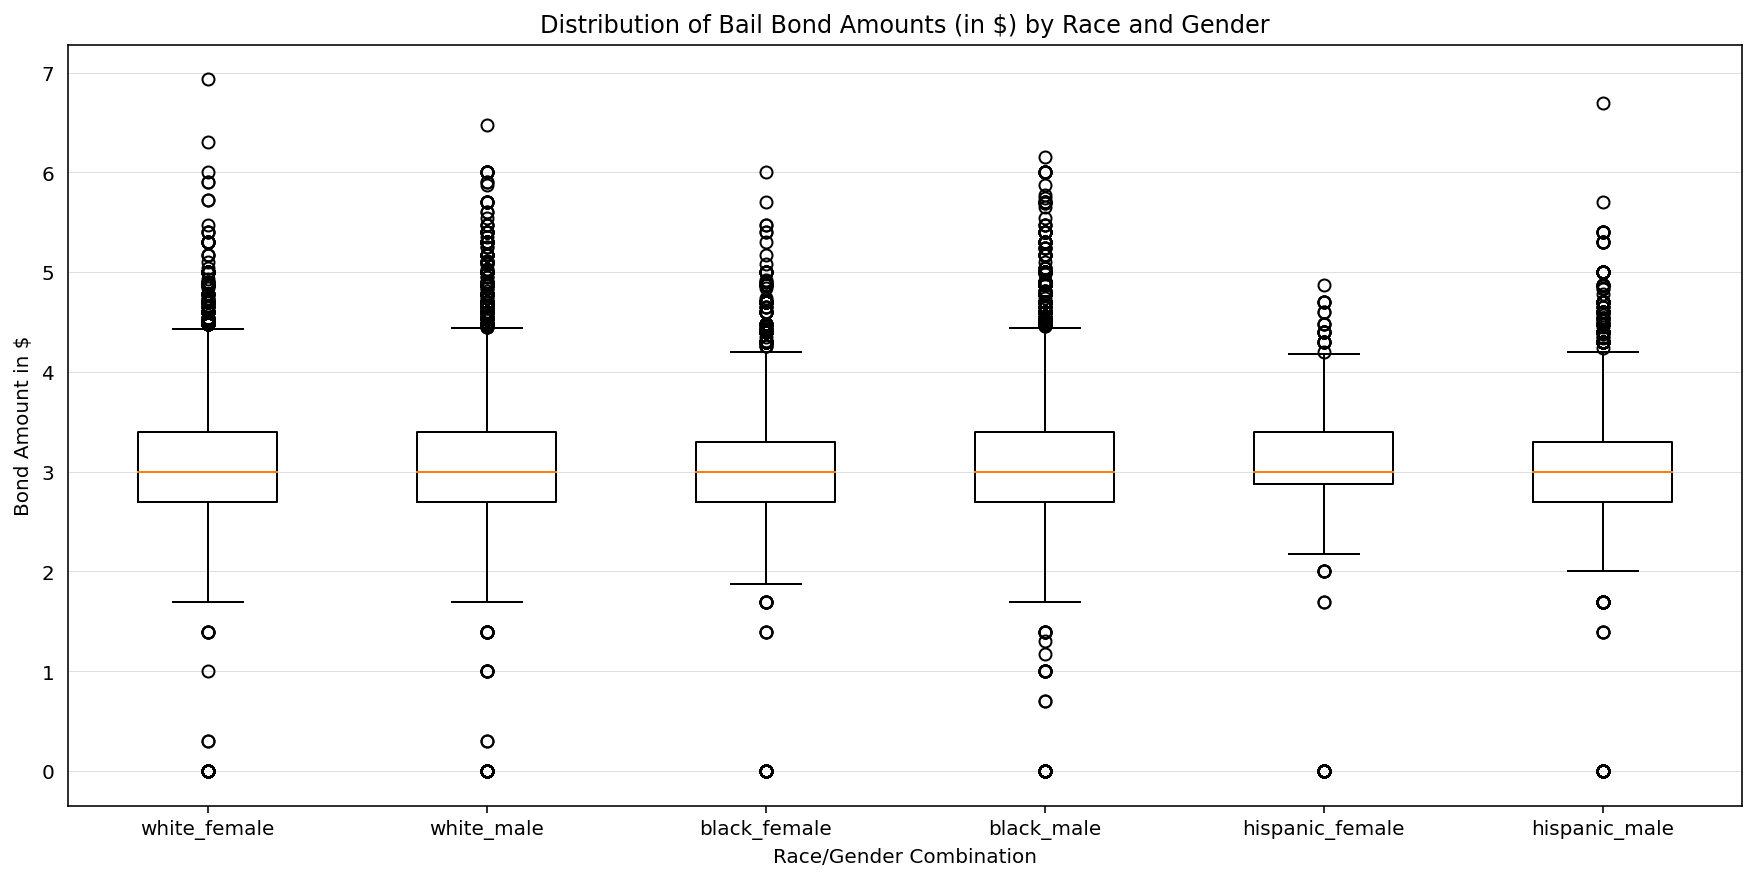

In [17]:
# Prepare & generate datasets
# LOG
white_female = np.log10(
    case_bond[case_bond["race_gender"] == "White Female"]["bond_amount"]
)
white_male = np.log10(
    case_bond[case_bond["race_gender"] == "White Male"]["bond_amount"]
)
black_female = np.log10(
    case_bond[case_bond["race_gender"] == "Black Female"]["bond_amount"]
)
black_male = np.log10(
    case_bond[case_bond["race_gender"] == "Black Male"]["bond_amount"]
)
hispanic_female = np.log10(
    case_bond[case_bond["race_gender"] == "Hispanic Female"]["bond_amount"]
)
hispanic_male = np.log10(
    case_bond[case_bond["race_gender"] == "Hispanic Male"]["bond_amount"]
)


# Visualize petal length distribution for all species
fig, ax = plt.subplots(figsize=(15, 7))

# Remove y-axis tick marks
ax.yaxis.set_ticks_position("none")
# Add major gridlines in the y-axis
ax.grid(color="grey", axis="y", linestyle="-", linewidth=0.25, alpha=0.5)
# Set plot title
ax.set_title("Distribution of Bail Bond Amounts (in $) by Race and Gender")
plt.xlabel("Race/Gender Combination")
plt.ylabel("Bond Amount in $")
# Set names as labels for the boxplot
dataset = [
    white_female,
    white_male,
    black_female,
    black_male,
    hispanic_female,
    hispanic_male,
]
ax.boxplot(
    dataset,
    labels=[
        "white_female",
        "white_male",
        "black_female",
        "black_male",
        "hispanic_female",
        "hispanic_male",
    ],
    showfliers=True,
)
plt.show()


# WHAT IF I GET RID OF OUTLIERS?


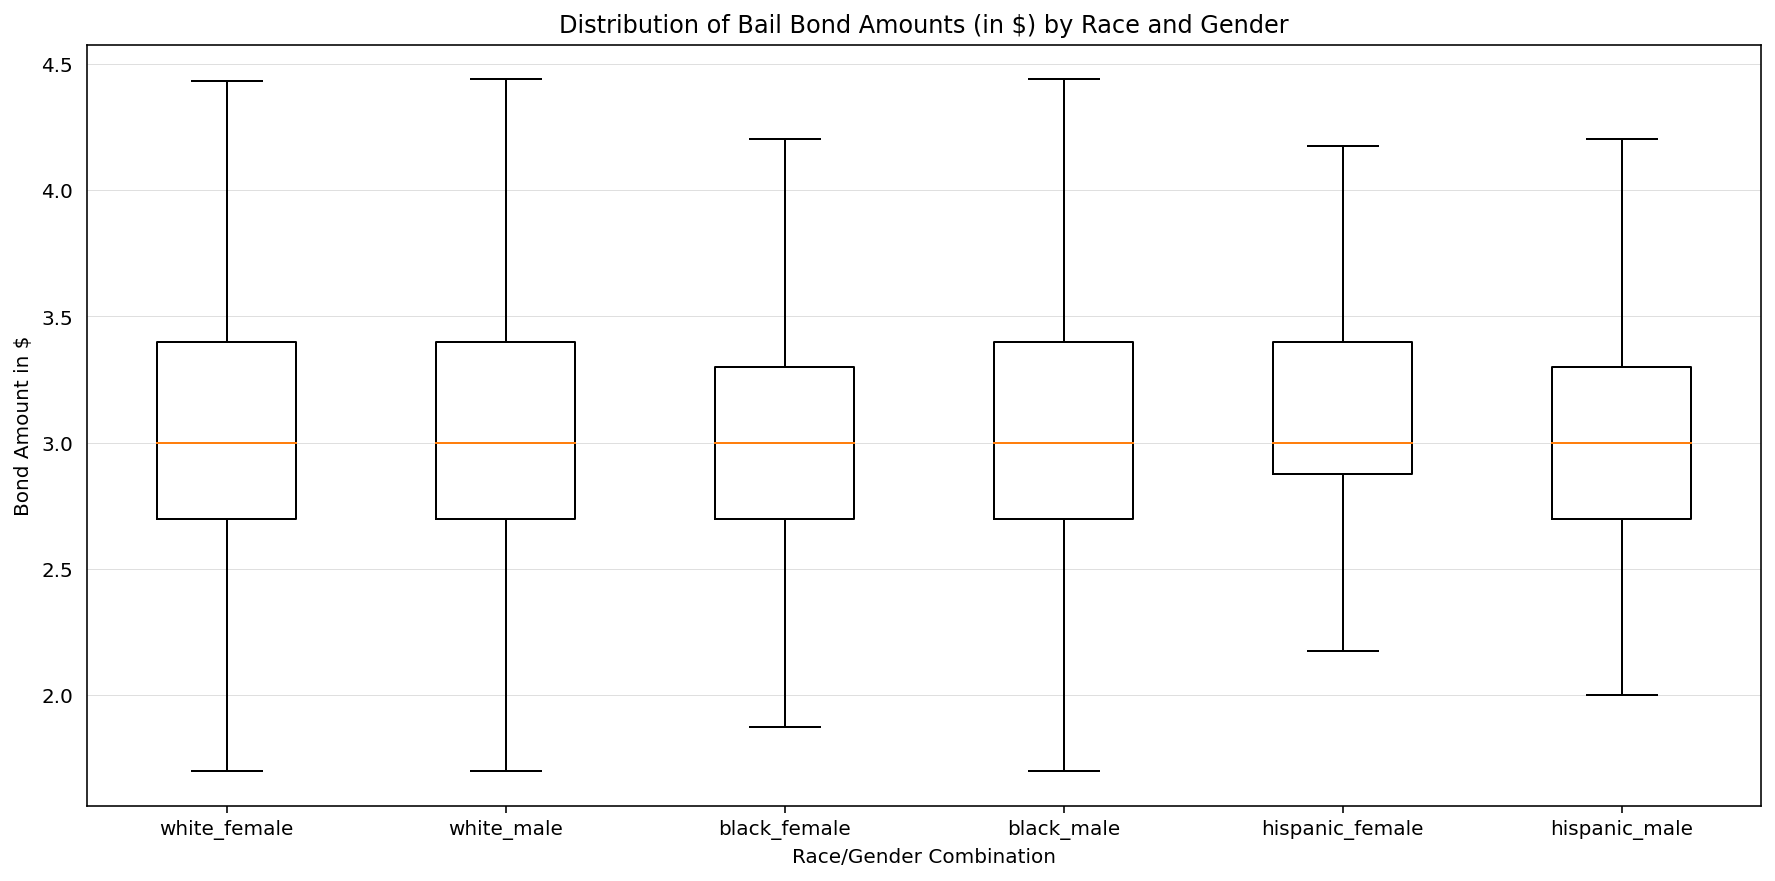

In [18]:
# REMOVED OUTLIERS (CHEATING)
fig, ax = plt.subplots(figsize=(15, 7))

# Remove y-axis tick marks
ax.yaxis.set_ticks_position("none")
# Add major gridlines in the y-axis
ax.grid(color="grey", axis="y", linestyle="-", linewidth=0.25, alpha=0.5)
# Set plot title
ax.set_title("Distribution of Bail Bond Amounts (in $) by Race and Gender")
plt.xlabel("Race/Gender Combination")
plt.ylabel("Bond Amount in $")
# Set names as labels for the boxplot
dataset = [
    white_female,
    white_male,
    black_female,
    black_male,
    hispanic_female,
    hispanic_male,
]
ax.boxplot(
    dataset,
    labels=[
        "white_female",
        "white_male",
        "black_female",
        "black_male",
        "hispanic_female",
        "hispanic_male",
    ],
    showfliers=False,
)
plt.show()


In [ ]:
# WHAT IF I ONLY LOOK AT ONE TYPE OF BOND

white_female = np.log10(
    case_bond[case_bond["race_gender"] == "White Female"]["bond_amount"]
)
white_male = np.log10(
    case_bond[case_bond["race_gender"] == "White Male"]["bond_amount"]
)
black_female = np.log10(
    case_bond[case_bond["race_gender"] == "Black Female"]["bond_amount"]
)
black_male = np.log10(
    case_bond[case_bond["race_gender"] == "Black Male"]["bond_amount"]
)
hispanic_female = np.log10(
    case_bond[case_bond["race_gender"] == "Hispanic Female"]["bond_amount"]
)
hispanic_male = np.log10(
    case_bond[case_bond["race_gender"] == "Hispanic Male"]["bond_amount"]
)


# Visualize petal length distribution for all species
fig, ax = plt.subplots(figsize=(15, 7))

# Remove y-axis tick marks
ax.yaxis.set_ticks_position("none")
# Add major gridlines in the y-axis
ax.grid(color="grey", axis="y", linestyle="-", linewidth=0.25, alpha=0.5)
# Set plot title
ax.set_title("Distribution of Bail Bond Amounts (in $) by Race and Gender")
plt.xlabel("Race/Gender Combination")
plt.ylabel("Bond Amount in $")
# Set names as labels for the boxplot
dataset = [
    white_female,
    white_male,
    black_female,
    black_male,
    hispanic_female,
    hispanic_male,
]
ax.boxplot(
    dataset,
    labels=[
        "white_female",
        "white_male",
        "black_female",
        "black_male",
        "hispanic_female",
        "hispanic_male",
    ],
    showfliers=True,
)
plt.show()


### Interpretation:

I want to say that these plots mean nothing, but if the NAs were truly random (and they seem to be), this is a hint that maybe the distributions arent that different. The differences are subtil. 
Note that:
* Distributions of bail amounts in % for each race-gender combo are NOT normal (they dont look normal)
* This is not statistical proof
* This is just one type of offense

In the next few boxes I am going to do a regression so we can see if race and gender have significant effects on bail amounts controling for type of offense and city of address of the defendant (i know that there's a lot more to it, but this is the information available)

# Regression (are races / genders correlated to higher or lower bail amouts?)
### Only for the most common bail-setting offense = DRIVING WHILE IMPAIRED

In [70]:
# Use only bond amounts that are not NA
bond_regression = case_off_desc.loc[~case_off_desc["bond_amount"].isna()]

bond_regression = bond_regression.loc[
    bond_regression["bond_type"].isin(["CSH", "CUS", "PTR", "SEC", "UNS", "WPA"])
]
# renaming that dumb colmns that has a space
bond_regression.rename(columns={"Offense Description": "off_description"}, inplace=True)


In [71]:
# OPTION 1 ------> Subset to top % of bail-requiring charges
bond_regression = bond_regression.loc[
    bond_regression["off_description"].isin(
        top_offences_with_bail.loc[top_offenses["%"] > 1].index.to_list()
    )
]


In [72]:
# OPTION 2 ------> Subset for ONE Charge (Driving WHile Impaired)
# bond_regression = bond_regression.loc[bond_regression["charged_offense_code"] == 5405]


In [73]:
# Reducing gender to F and M
bond_regression.sex.value_counts()
bond_regression = bond_regression[bond_regression["sex"].isin(["M", "F"])]


In [74]:
# Reducing race to white, black, hispanic (other subsets may not be as representative)
bond_regression.race.value_counts()
bond_regression = bond_regression[bond_regression["race"].isin(["W", "B", "H"])]


In [24]:
# Cities with the largest amount of these crimes
# cities = pd.DataFrame(bond_regression.def_city_address.value_counts())
# cities['%']=100 * cities['def_city_address'] / np.sum(cities['def_city_address'])

# bond_regression = bond_regression.loc[bond_regression['def_city_address'].isin(cities.loc[cities["%"] > 1].index.to_list())]


In [75]:
# ADD county number (represents court?)
bond_regression["key_county_num"].isna().sum() # no NAs
bond_regression["key_county_num"] = bond_regression["key_county_num"].astype(str)
bond_regression["key_county_num"].dtypes


dtype('O')

In [80]:
#court type
bond_regression['court_type'].isna().sum() # no NAs
bond_regression['court_type'].value_counts()

CR     1937532
CRS     338484
Name: court_type, dtype: int64

In [88]:
# offense class!
bond_regression['offense_class'].isna().sum() # too many NAs
bond_regression['CL'].value_counts()

1    747510
3    514953
2    321318
Name: CL, dtype: int64

In [60]:
# So, I thought because the offense is the same it would have the same class!
bond_regression["offense_class"].value_counts()

bond_regression.loc[bond_regression["offense_class"] == "1.0", "offense_class"] = "1"
bond_regression.loc[bond_regression["offense_class"] == "2.0", "offense_class"] = "2"
bond_regression.loc[bond_regression["offense_class"] == "3.0", "offense_class"] = "3"

bond_regression = bond_regression.loc[
    bond_regression["offense_class"].isin(["1", "2", "3"])
]
bond_regression["offense_class"].value_counts()

/Users/clarissaache/opt/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


1    182291
3     99082
2     67073
Name: offense_class, dtype: int64

In [67]:
import statsmodels.formula.api as smf

m = smf.ols(
    "bond_amount ~ C(race) * C(sex) + C(bond_type) + C(off_description) + C(disposition) + C(key_county_num) + court_type",
    bond_regression,
).fit()
m.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            bond_amount   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     29.58
Date:                Fri, 13 Jan 2023   Prob (F-statistic):               0.00
Time:                        11:37:04   Log-Likelihood:            -6.5672e+06
No. Observations:              565916   AIC:                         1.313e+07
Df Residuals:                  565774   BIC:                         1.314e+07
Df Model:                         141                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                              1.51e+14      3e+15      0.050      0.960   -5.72e+15    6.02e+15
C(race)[T.H]                                           126.5484    427.978      0.296      0.767    -712.274     965.371
C(race)[T.W]                                           372.3789    148.984      2.499      0.012      80.375     664.383
C(sex)[T.M]                                            717.5328    127.524      5.627      0.000     467.589     967.477
C(bond_type)[T.CUS]                                  -1956.4750    518.497     -3.773      0.000   -2972.712    -940.238
C(bond_type)[T.PTR]                                   2784.4812   2285.503      1.218      0.223   -1695.032    7263.994
C(bond_type)[T.SEC]                                   1032.5145    142.445      7.248      0.000     753.326    1311.703
C(bond_type)[T.UNS]                                     72.3340    163.047      0.444      0.657    -247.233     391.900
C(bond_type)[T.WPA]                                  -1782.9065    432.908     -4.118      0.000   -2631.392    -934.421
C(off_description)[T.CIVIL REVOCATION DR LIC (30)]     1.49e+11   2.96e+12      0.050      0.960   -5.64e+12    5.94e+12
C(off_description)[T.DRIVE/ALLOW MV NO REGISTRATION]  -482.7490    997.130     -0.484      0.628   -2437.093    1471.595
C(off_description)[T.DRIVING WHILE IMPAIRED]          1492.0841    750.922      1.987      0.047      20.300    2963.868
C(off_description)[T.DWLR]                             689.8742    759.395      0.908      0.364    -798.516    2178.264
C(off_description)[T.DWLR NOT IMPAIRED REV]            422.6685    756.048      0.559      0.576   -1059.162    1904.499
C(off_description)[T.EXPIRED REGISTRATION CARD/TAG]    258.0443    837.760      0.308      0.758   -1383.939    1900.028
C(off_description)[T.EXPIRED/NO INSPECTION]           -441.2472   1336.605     -0.330      0.741   -3060.951    2178.456
C(off_description)[T.FICT/ALT TITLE/REG CARD/TAG]     1294.2387    868.823      1.490      0.136    -408.627    2997.105
C(off_description)[T.MISDEMEANOR LARCENY]             1759.6177    752.849      2.337      0.019     284.058    3235.177
C(off_description)[T.MISDEMEANOR PROBATION VIOL]      2433.8628   7786.613      0.313      0.755   -1.28e+04    1.77e+04
C(off_description)[T.NO OPERATORS LICENSE]             309.5339    769.597      0.402      0.688   -1198.851    1817.919
C(off_description)[T.OPERATE VEH NO INS]              -165.1618    807.370     -0.205      0.838   -1747.581    1417.257
C(off_description)[T.POSSESS DRUG PARAPHERNALIA]      3966.1005    755.756      5.248      0.000    2484.843    5447.358
C(off_description)[T.POSSESS MARIJUANA UP TO 1/2 OZ]  1393